In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import libraries and data

In [ ]:
# import libraries
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import requests
import zipfile
from io import BytesIO
import shutil

In [ ]:
# Load processed data from GitHub
dataset_url = "https://github.com/vnpq/CapyData_SportImageClassifier/archive/refs/heads/main.zip"
dataset_dir = "CapyData_SportImageClassifier-main/data/ic_dataset"
if not os.path.exists("ic_dataset"):
    print("Downloading dataset...")
    response = requests.get(dataset_url)
    with zipfile.ZipFile(BytesIO(response.content)) as z:
        z.extractall()
    print("Extracted dataset.")
    shutil.move(dataset_dir, "ic_dataset")
    shutil.rmtree("CapyData_SportImageClassifier-main")
else:
    print("Dataset already exists.")

# Load annotation
vocab_dir = "ic_dataset/vocab"
with open(os.path.join(vocab_dir, "vocab.json"), "r", encoding="utf-8") as f:
    vocab = json.load(f)
    vocab = {k: int(v) for k, v in vocab.items()}
with open(os.path.join(vocab_dir, "idx_to_word.json"), "r", encoding="utf-8") as f:
    idx_to_word = json.load(f)
    idx_to_word = {int(k): v for k, v in idx_to_word.items()}
    inv_vocab = idx_to_word

Extracted dataset.


## Define functions/classes

In [ ]:
# Dataset class
class ImageCaptionDataset(Dataset):
    def __init__(self, image_dir, captions_file, vocab, transform=None):
        self.image_dir = image_dir
        self.vocab = vocab
        self.transform = transform

        self.data = []
        with open(captions_file, 'r', encoding='utf-8') as f:
            for line in f:
                img_name, caption = line.strip().split('\t')
                tokens = caption.strip().split()
                self.data.append((img_name, tokens))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, tokens = self.data[idx]
        image_path = os.path.join(self.image_dir, img_name)
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        caption = [self.vocab['<s>']] + [self.vocab.get(token, self.vocab['<unk>']) for token in tokens] + [self.vocab['</s>']]
        return image, torch.tensor(caption), img_name, tokens

def collate_fn(batch):
    images, captions, img_names, raw_tokens = zip(*batch)
    images = torch.stack(images)
    captions = pad_sequence(captions, batch_first=True, padding_value=vocab['<pad>'])
    return images, captions, img_names, raw_tokens

In [ ]:
# Encoder CNN
class EncoderCNN(nn.Module):
    def __init__(self, encoded_size=256):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        for param in resnet.parameters():
            param.requires_grad = False
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(2048, encoded_size)
        self.bn = nn.BatchNorm1d(encoded_size)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, images):
        features = self.resnet(images)
        features = self.adaptive_pool(features)
        features = features.view(features.size(0), -1)
        features = self.fc(features)
        features = self.bn(features)
        return features

# Attention mechanism
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden).unsqueeze(1)
        att = self.full_att(torch.tanh(att1 + att2)).squeeze(2)
        alpha = torch.softmax(att, dim=1)
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return context, alpha

# Decoder RNN
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, encoder_dim=256, attention_dim=256):
        super().__init__()
        self.attention = Attention(encoder_dim, hidden_size, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTMCell(embed_size + encoder_dim, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
        self.hidden_size = hidden_size

    def forward(self, encoder_out, captions):
        batch_size = encoder_out.size(0)
        vocab_size = self.fc.out_features
        embeddings = self.embedding(captions)

        h, c = torch.zeros(batch_size, self.hidden_size).to(encoder_out.device), torch.zeros(batch_size, self.hidden_size).to(encoder_out.device)
        outputs = torch.zeros(batch_size, captions.size(1), vocab_size).to(encoder_out.device)

        for t in range(captions.size(1)):
            context, _ = self.attention(encoder_out.unsqueeze(1), h)
            input_lstm = torch.cat([embeddings[:, t], context], dim=1)
            h, c = self.lstm(input_lstm, (h, c))
            h = self.dropout(h)
            outputs[:, t] = self.fc(h)

        return outputs

# Combined Model
class ImageCaptionModel(nn.Module):
    def __init__(self, encoded_size=256, embed_size=256, hidden_size=512, vocab_size=len(vocab), attention_dim=256):
        super().__init__()
        self.encoder = EncoderCNN(encoded_size=encoded_size)
        self.decoder = DecoderRNN(embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size, 
                                 encoder_dim=encoded_size, attention_dim=attention_dim)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    @torch.no_grad()
    def generate_caption(self, image, vocab, idx_to_word, max_length=20, beam_width=5):
        self.eval()
        image = image.unsqueeze(0).to(image.device)
        features = self.encoder(image).unsqueeze(1)  # [1, 1, encoded_size]

        # Beam search
        sequences = [[[], 0.0, [features, None]]]  # [sequence, score, [features, (h, c)]]
        for _ in range(max_length):
            all_candidates = []
            for seq, score, state in sequences:
                if len(seq) > 0 and seq[-1] == vocab["</s>"]:
                    all_candidates.append([seq, score, state])
                    continue

                # Get the last token
                if len(seq) == 0:
                    token = torch.tensor([[vocab["<s>"]]], device=image.device)
                else:
                    token = torch.tensor([[seq[-1]]], device=image.device)

                # Embedding and LSTM
                embed = self.decoder.embedding(token)  # [1, 1, embed_size]
                context, _ = self.decoder.attention(state[0], state[1][0] if state[1] else torch.zeros(1, self.decoder.hidden_size).to(image.device))
                input_lstm = torch.cat([embed.squeeze(1), context], dim=1)
                if state[1] is None:
                    h, c = self.decoder.lstm(input_lstm)
                else:
                    h, c = self.decoder.lstm(input_lstm, state[1])

                output = self.decoder.fc(h)  # [1, vocab_size]
                output = torch.softmax(output, dim=-1)

                # Get top k tokens
                top_probs, top_indices = output.topk(beam_width)
                for i in range(beam_width):
                    next_seq = seq + [top_indices[0, i].item()]
                    next_score = score + torch.log(top_probs[0, i]).item()
                    all_candidates.append([next_seq, next_score, [features, (h, c)]])

            # Select top k sequences
            sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]

        # Convert sequences to captions
        captions = []
        for seq, score, _ in sequences:
            caption = [idx_to_word.get(idx, "<unk>") for idx in seq if idx not in [vocab["<s>"], vocab["</s>"]]]
            captions.append(" ".join(caption))

        return captions

# Early stopping
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model, model_path='model_cla.pth'):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), model_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, captions, _, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, captions = images.to(device), captions.to(device)
            optimizer.zero_grad()
            outputs = model(images, captions[:, :-1])
            loss = criterion(outputs.reshape(-1, outputs.size(2)), captions[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, captions, _, _ in val_loader:
                images, captions = images.to(device), captions.to(device)
                outputs = model(images, captions[:, :-1])
                val_loss += criterion(outputs.reshape(-1, outputs.size(2)), captions[:, 1:].reshape(-1)).item()
        
        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        
        # Save checkpoint periodically
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            torch.save(model.state_dict(), f'model_epoch_{epoch}.pth')
        
        # Early stopping check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    # Load best model
    model.load_state_dict(torch.load('model_cla.pth', weights_only=True))
    return model

## Train model

In [ ]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = ImageCaptionDataset('ic_dataset/train/images', 
                                    'ic_dataset/train/captions.txt', 
                                    vocab, transform)
val_dataset = ImageCaptionDataset('ic_dataset/val/images', 
                                  'ic_dataset/val/captions.txt', 
                                  vocab, transform)
test_dataset = ImageCaptionDataset('ic_dataset/test/images', 
                                   'ic_dataset/test/captions.txt', 
                                   vocab, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [ ]:
# Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImageCaptionModel(encoded_size=256, embed_size=256, hidden_size=512, vocab_size=len(vocab)).to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
early_stopping = EarlyStopping(patience=3)

# Train the model
print(f"Training on device: {device}")
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


Training on device: cuda


Epoch 1/20: 100%|██████████| 197/197 [02:11<00:00,  1.49it/s]


Epoch 1/20, Train Loss: 6.1309, Validation Loss: 5.2578


Epoch 2/20: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 2/20, Train Loss: 5.0832, Validation Loss: 4.8891


Epoch 3/20: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 3/20, Train Loss: 4.7624, Validation Loss: 4.6328


Epoch 4/20: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 4/20, Train Loss: 4.5049, Validation Loss: 4.4268


Epoch 5/20: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 5/20, Train Loss: 4.3019, Validation Loss: 4.2785


Epoch 6/20: 100%|██████████| 197/197 [02:09<00:00,  1.52it/s]


Epoch 6/20, Train Loss: 4.1364, Validation Loss: 4.1319


Epoch 7/20: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 7/20, Train Loss: 3.9932, Validation Loss: 4.0299


Epoch 8/20: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 8/20, Train Loss: 3.8744, Validation Loss: 3.9334


Epoch 9/20: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 9/20, Train Loss: 3.7764, Validation Loss: 3.8578


Epoch 10/20: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 10/20, Train Loss: 3.6841, Validation Loss: 3.7951


Epoch 11/20: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 11/20, Train Loss: 3.6007, Validation Loss: 3.7478


Epoch 12/20: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 12/20, Train Loss: 3.5322, Validation Loss: 3.6916


Epoch 13/20: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 13/20, Train Loss: 3.4669, Validation Loss: 3.6554


Epoch 14/20: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 14/20, Train Loss: 3.4056, Validation Loss: 3.6087


Epoch 15/20: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 15/20, Train Loss: 3.3437, Validation Loss: 3.5795


Epoch 16/20: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 16/20, Train Loss: 3.2985, Validation Loss: 3.5504


Epoch 17/20: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 17/20, Train Loss: 3.2498, Validation Loss: 3.5254


Epoch 18/20: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 18/20, Train Loss: 3.2019, Validation Loss: 3.5025


Epoch 19/20: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 19/20, Train Loss: 3.1599, Validation Loss: 3.4776


Epoch 20/20: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 20/20, Train Loss: 3.1189, Validation Loss: 3.4532


## Test

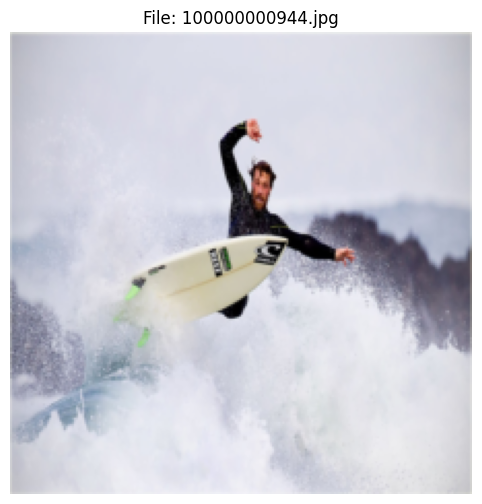


📌 Ground truth captions:
- vận_động_viên mặc trang_phục đen lướt trên sóng mạnh tận_dụng hoàn_hảo điều_kiện biển động

🤖 Generated captions:
1: người vận_động_viên đang thực_hiện cú nhảy mạnh_mẽ trên ván lướt <unk>
2: người vận_động_viên đang thực_hiện cú nhảy mạnh_mẽ trên ván lướt qua sóng lớn
3: người vận_động_viên đang thực_hiện cú nhảy mạnh_mẽ trên ván lướt tạo nên khung_cảnh tuyệt đẹp
4: người vận_động_viên đang thực_hiện cú nhảy mạnh_mẽ trên ván lướt tạo ra sóng lớn
5: người vận_động_viên đang thực_hiện cú nhảy mạnh_mẽ trên ván lướt tạo nên những bọt nước


In [ ]:
# Test on a random image
images, captions, img_names, raw_tokens = next(iter(test_loader))
image = images[0]
img_name = img_names[0]

# Display image
plt.figure(figsize=(8, 6))
plt.imshow(image.permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
plt.title(f"File: {img_name}")
plt.axis('off')
plt.show()

# Print ground truth captions
print("\n📌 Ground truth captions:")
for cap in raw_tokens:
    print("-", ' '.join(cap))

# Print generated captions
print("\n🤖 Generated captions:")
captions = model.generate_caption(image.to(device), vocab, inv_vocab, max_length=20, beam_width=5)
for i, cap in enumerate(captions):
    print(f"{i+1}:", cap)